In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
import time
from pathlib import Path

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [3]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [4]:
path = '/Volumes/RTO/C Brace/GPS Analysis/' #mac
# path = 'X:/C Brace/GPS Analysis/' #win
# path = 'Z:/C Brace/GPS Analysis/'


# Calculate Features

In [5]:
path_procfiles = os.path.join(path,'UIC_GPSData/w_Steps')

In [6]:
f = os.listdir(path_procfiles)[0]
print(f)

CBR21_CBrace.csv


In [9]:
data = pd.read_csv(Path(path_procfiles)/f)
del data['Unnamed: 0']
del data['Unnamed: 0.1']
del data['Unnamed: 0.1.1']
data.head()

,Date,Sequence,BeginTime,EndTime,Mode,LandUse,MeanSpeed,Numberpoints,TotalGap,Duration,...,Gap_Max,Gap_Mean,Gap_Median,LocID,DistHome,Steps,Cadence,Time walking,Steps per Hour,Steps per Hour Wear
0,2016-08-18,1,15:18:57,15:53:57,NaN,Com_office,0.527363,27,90.916667,0.024306,...,1850.0,80.769231,10.0,1,5442.413371,120,0.222222,540,205.714286,205.714286
1,2016-08-18,2,15:54:07,16:19:47,Car,Trip,33.155807,155,0.000000,0.017824,...,10.0,10.000000,10.0,-1,-1.000000,1,0.100000,10,2.337662,2.337662
2,2016-08-18,3,16:19:57,19:06:17,NaN,Res_sf_attached,0.215601,1000,0.000000,0.115509,...,10.0,9.989990,10.0,2,12229.512267,0,NaN,0,0.000000,0.000000
3,2016-08-18,4,19:06:27,19:23:37,Car,Trip,35.997711,104,0.000000,0.011921,...,10.0,10.000000,10.0,-1,-1.000000,4,0.100000,40,13.980583,13.980583
4,2016-08-18,5,19:23:47,21:09:17,NaN,Inst_religious,0.230411,634,0.000000,0.073264,...,10.0,10.000000,10.0,3,6302.016284,0,NaN,0,0.000000,0.000000


In [70]:
data.Mode.unique()

array([nan, 'Car', 'Walk'], dtype=object)

In [10]:
data[data.Mode=='Car']['Speed_Median']

1      29.719219
3      40.192213
5      46.385415
8      39.493252
10     31.156977
         ...    
200    39.616081
203    38.482948
205    50.340176
207    72.504288
210    41.240620
Name: Speed_Median, Length: 92, dtype: float64

**Retrieve Home Data only**

In [21]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = d['LandUse']=='Home' #to retrieve home data
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        d = d[DestinationInd]
        Data = pd.concat([Data,d]) #concatenate data from each subj 
    else:
        #skip directories
        continue

In [22]:
Data=Data.drop('Unnamed: 0.1.1',axis=1)
Data.columns

Index(['Date', 'Sequence', 'BeginTime', 'EndTime', 'Mode', 'LandUse',
       'MeanSpeed', 'Numberpoints', 'TotalGap', 'Duration', 'Mean Lat',
       'Mean Lon', 'Wear Frac', 'Numpoints', 'Speed_Mean', 'Speed_Min',
       'Speed_Max', 'Speed_Median', 'Gap_Min', 'Gap_Max', 'Gap_Mean',
       'Gap_Median', 'LocID', 'DistHome', 'Steps', 'Cadence', 'Time walking',
       'Steps per Hour', 'Steps per Hour Wear', 'SubjID', 'Brace',
       'MaximumSpeed', 'MinimumSpeed'],
      dtype='object')

In [23]:
Data.SubjID.unique()

array(['CBR21', 'CBR30', 'CBR22', 'CBR24', 'CBR27', 'CBR26', 'CBR11',
       'CBR16', 'CBR28', 'CBR31', 'CBR15', 'CBR19', 'CBR25', 'CBR08'],
      dtype=object)

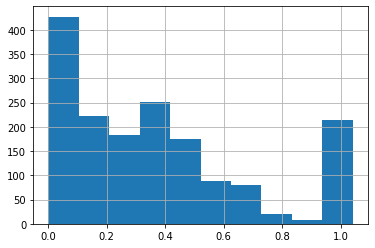

In [25]:
Data['Duration'].hist()

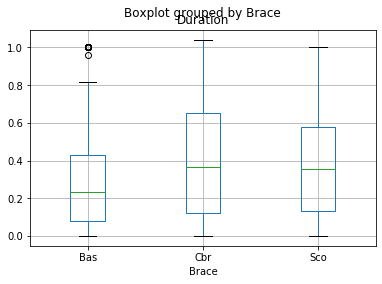

In [26]:
Data.boxplot(column='Duration',by='Brace')

In [27]:
#assign new brace category
Data['NewBrace']=0

In [28]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Sco' 'Bas']
CBR30 ['Bas' 'Cbr' 'Sco']
CBR22 ['Cbr' 'Sco' 'Bas']
CBR24 ['Sco' 'Cbr' 'Bas']
CBR27 ['Sco' 'Bas' 'Cbr']
CBR26 ['Bas' 'Cbr' 'Sco']
CBR11 ['Cbr' 'Bas' 'Sco']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas' 'Sco']
CBR31 ['Sco' 'Bas' 'Cbr']
CBR15 ['Cbr' 'Bas' 'Sco']
CBR19 ['Sco' 'Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']


In [29]:
Data=Data.reset_index(drop=True)
#add label of new brace
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1
    else: #if only SCO or Cbr data exists
        if 'Cbr' in Data[Data['SubjID']==s].Brace.unique():
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1    
        else:
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1    
            

In [30]:
#To remove SCO data (for speed analysis) if 3 devices exist
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        inds= np.where((Data['SubjID']==s) & (Data['Brace']=='Sco'))[0]
        Data=Data.drop(inds)
        Data=Data.reset_index(drop=True)
len(Data)  

1303

In [31]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Bas']
CBR30 ['Bas' 'Cbr']
CBR22 ['Cbr' 'Bas']
CBR27 ['Bas' 'Cbr']
CBR26 ['Bas' 'Cbr']
CBR11 ['Cbr' 'Bas']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas']
CBR15 ['Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR19 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']
CBR24 ['Cbr' 'Bas']
CBR31 ['Bas' 'Cbr']


In [32]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [35]:
Features['Duration'] = (Data['Duration']*24)
Features['Mean Speed'] = Data['Speed_Mean']
Features['SubjID'] = Data['SubjID']
Features['NewBrace'] = Data['NewBrace']
Features['LocID'] = Data['LocID']
Features['Steps'] = Data['Steps']
Features['Cadence'] = Data['Cadence']
Features['Steps per Hour'] = Data['Steps per Hour']
Features['Steps per Hour Wear'] = Data['Steps per Hour Wear']
Features['Date'] = Data['Date']

In [36]:
Features[Features.SubjID=='CBR21']

,Wear Frac,Duration,Mean Speed,SubjID,NewBrace,LocID,Steps,Steps per Hour,Steps per Hour Wear,Date,Cadence
0,0.033473,2.652778,0.076119,CBR21,1,0,30,11.308901,337.853403,2016-08-18,0.333333
1,0.000000,18.044444,0.037787,CBR21,1,0,0,0.000000,NaN,2016-08-19,NaN
2,0.000000,4.041667,0.063728,CBR21,1,0,0,0.000000,NaN,2016-08-19,NaN
3,0.000000,12.708333,0.046796,CBR21,1,0,0,0.000000,NaN,2016-08-20,NaN
4,0.000000,1.600000,0.212844,CBR21,1,0,0,0.000000,NaN,2016-08-20,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1011,0.000000,9.832500,0.043803,CBR21,0,0,0,0.000000,NaN,2016-01-19,NaN
1012,0.000000,10.123889,0.108452,CBR21,0,0,0,0.000000,NaN,2016-01-19,NaN
1013,0.000000,8.155833,0.056561,CBR21,0,0,0,0.000000,NaN,2016-01-20,NaN
1014,0.000000,7.810833,0.106688,CBR21,0,0,0,0.000000,NaN,2016-01-20,NaN


In [37]:
demographics = pd.read_excel('../Data/Demographics_analysis.xlsx')
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].values]

In [38]:
Features.to_csv('../Data/GPSandClinicalData_Home.csv',index=False)

**Retrieve Destinations data only**

In [46]:
d = pd.read_csv(Path(path_procfiles)/os.listdir(path_procfiles)[0])

In [47]:
d.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Date', 'Sequence',
       'BeginTime', 'EndTime', 'Mode', 'LandUse', 'MeanSpeed', 'Numberpoints',
       'TotalGap', 'Duration', 'Mean Lat', 'Mean Lon', 'Wear Frac',
       'Numpoints', 'Speed_Mean', 'Speed_Min', 'Speed_Max', 'Speed_Median',
       'Gap_Min', 'Gap_Max', 'Gap_Mean', 'Gap_Median', 'LocID', 'DistHome',
       'Steps', 'Cadence', 'Time walking', 'Steps per Hour',
       'Steps per Hour Wear'],
      dtype='object')

In [12]:
def getTripDur(PreDestInd,Data):
    d = Data[PreDestInd]
    TripDur=[]
    for i in range(len(d)):
        if d['LandUse'].iloc[i]=='Trip':
            TripDur.append(d['Duration'][i])
        else:
            TripDur.append(np.float('nan'))
            
    return pd.Series(TripDur)

In [144]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = (d['LandUse']!='Home')&(d['LandUse']!='Trip')
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        
#         print(sum(DestinationInd), sum(d['LandUse']=='Trip'))
        
        # Calculate trip features
        PreDestInd = DestinationInd[1::]
        PreDestInd = PreDestInd.append(pd.Series(False))
#         print(d[PreDestInd]['LandUse'].unique())

#         TripMode = pd.Series(np.float('nan')).append(d[PreDestInd]['Mode'])
        TripMode = d[PreDestInd]['Mode']
#         TripDuration = pd.Series(np.float('nan')).append(getTripDur(PreDestInd,d))
        TripDuration = getTripDur(PreDestInd,d)
        
        # Calculate aggregate features
        d = d[DestinationInd]
        d['Relative Freq'] = pd.Series([sum(d['LocID']==x)/sum(DestinationInd) for x in d['LocID']]).values
        d['Relative Duration'] = pd.Series([sum(d[d['LocID']==x]['Duration'])/sum(d['Duration']) for x in d['LocID']]).values
#         print(np.sum(np.unique(d['Relative Duration'])))
        d['TripMode'] = TripMode.values
        d['TripDuration'] = TripDuration.values
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

OtherDestInd = (Data['LandUse']!='Inst')&(Data['LandUse']!='Res')&(Data['LandUse']!='Com')&(Data['LandUse']!='Os')
Data.loc[OtherDestInd,'LandUse'] = 'Other'

/Users/luca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/luca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/luca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/Users/luca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/luca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will 

In [148]:
newbrace = 'Cbr'
for s in Data.SubjID.unique():
    Data_ = Data[(Data['SubjID']==s)&(Data['Brace']==newbrace)]
    print(s,np.sum(np.unique(Data_['Relative Duration'])),len(np.unique(Data_['Relative Duration'])), len(np.unique(Data_['LocID'])))


CBR21 1.0000000000000002 39 39
CBR30 0.9976407575081299 82 83
CBR22 0.9991856556952281 28 29
CBR24 1.0 20 20
CBR27 0.0 0 0
CBR26 0.9907811777156934 30 33
CBR11 0.9965563598074217 52 57
CBR16 0.9974227278584709 30 31
CBR28 1.0 4 4
CBR31 0.9954183747287193 19 20
CBR15 0.9999999999999999 11 11
CBR19 1.0 4 4
CBR25 1.0 12 12
CBR08 0.9929137779139692 24 25


In [218]:
Data.columns

Index(['Unnamed: 0.1.1', 'Date', 'Sequence', 'BeginTime', 'EndTime', 'Mode',
       'LandUse', 'MeanSpeed', 'Numberpoints', 'TotalGap', 'Duration',
       'Mean Lat', 'Mean Lon', 'Wear Frac', 'Numpoints', 'Speed_Mean',
       'Speed_Min', 'Speed_Max', 'Speed_Median', 'Gap_Min', 'Gap_Max',
       'Gap_Mean', 'Gap_Median', 'LocID', 'DistHome', 'Steps', 'Cadence',
       'Time walking', 'Steps per Hour', 'Steps per Hour Wear', 'SubjID',
       'Brace', 'Relative Freq', 'Relative Duration', 'TripMode',
       'TripDuration', 'MaximumSpeed', 'MinimumSpeed', 'NewBrace'],
      dtype='object')

In [32]:
Data.Sequence.unique()

array([ 3,  5,  7, 11,  9, 13,  1, 15,  6,  8, 10, 12, 14,  2,  4, 16, 18,
       20, 22, 17, 19, 21, 23, 25, 29, 27, 31, 35, 33, 37, 39, 26, 28, 30,
       32, 34, 36, 40, 44, 41, 43, 45, 47, 49, 24, 38])

In [149]:
Datacopy = Data.copy()

In [150]:
Data=Datacopy.copy()

In [151]:
Data=Data.reset_index(drop=True)
Data.head()
print(len(Data))

2653


In [152]:
#assign new brace category
Data['NewBrace']=0

In [153]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Sco' 'Bas']
CBR30 ['Bas' 'Cbr' 'Sco']
CBR22 ['Cbr' 'Sco' 'Bas']
CBR24 ['Sco' 'Cbr' 'Bas']
CBR27 ['Sco' 'Bas']
CBR26 ['Bas' 'Cbr' 'Sco']
CBR11 ['Cbr' 'Bas' 'Sco']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas' 'Sco']
CBR31 ['Sco' 'Bas' 'Cbr']
CBR15 ['Cbr' 'Bas' 'Sco']
CBR19 ['Sco' 'Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']


In [154]:
#add label of new brace
for s in Data.SubjID.unique():
#     print(Data[Data['SubjID']==s].Brace.unique())
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1
        Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1
    else: #if only SCO or Cbr data exists
        if 'Cbr' in Data[Data['SubjID']==s].Brace.unique():
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Cbr'),'NewBrace']=1    
        else:
            Data.loc[(Data['SubjID']==s) & (Data['Brace']=='Sco'),'NewBrace']=1    
            

In [155]:
#To remove SCO data (for speed analysis) if 3 devices exist
for s in Data.SubjID.unique():
    if len(Data[Data['SubjID']==s].Brace.unique()) > 2: #if baseline device data exists, assumes CBR and SCO are both the new brace
        inds= np.where(((Data['SubjID']==s) & (Data['Brace']=='Sco')))[0]
        Data=Data.drop(inds)
        Data=Data.reset_index(drop=True)
len(Data)  

2181

In [156]:
for s in Data.SubjID.unique():
    print(s,Data[Data['SubjID']==s].Brace.unique())


CBR21 ['Cbr' 'Bas']
CBR30 ['Bas' 'Cbr']
CBR22 ['Cbr' 'Bas']
CBR27 ['Sco' 'Bas']
CBR26 ['Bas' 'Cbr']
CBR11 ['Cbr' 'Bas']
CBR16 ['Cbr' 'Sco']
CBR28 ['Cbr' 'Bas']
CBR15 ['Cbr' 'Bas']
CBR25 ['Cbr' 'Bas']
CBR19 ['Cbr' 'Bas']
CBR08 ['Sco' 'Cbr']
CBR24 ['Cbr' 'Bas']
CBR31 ['Bas' 'Cbr']


In [104]:
# Data.to_csv('GPSData.csv',index=False)

In [157]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [172]:
Features['DestinationType'] = Data['LandUse']
Features['Distance'] = (Data['DistHome']/1000)
Features['Duration'] = (Data['Duration']*24)
Features['Mean Speed'] = Data['Speed_Mean']
# Features['TripMode'] = Data['TripMode'].as_matrix()
Features['TripDuration'] = Data['TripDuration']
Features['Relative_Freq'] = Data['Relative Freq']
Features['Relative_Duration'] = Data['Relative Duration']
Features['SubjID'] = Data['SubjID']
# Features['Brace'] = Data['Brace'].as_matrix()
Features['NewBrace'] = Data['NewBrace']
Features['Steps'] = Data['Steps']
Features['Cadence'] = Data['Cadence']
Features['Steps per Hour'] = Data['Steps per Hour']
Features['Steps per Hour Wear'] = Data['Steps per Hour Wear']
Features['Date'] = Data['Date']

In [170]:
demographics = pd.read_excel('../Data/Demographics_analysis.xlsx')
demographics.columns

Index(['SubjID', 'median WT CBR', 'median WT SCO', 'median WT Baseline',
       'med sph CBR', 'med sph SCO', 'med sph Baseline', 'y of baseline use',
       'Diagnosis', 'Short Diagnosis', 'Age', 'Ncluster CBR',
       'MeanAwayTime CBR', 'Away/Home Time CBR', 'Home_WT CBR', 'Away_WT CBR',
       'Ncluster SCO', 'MeanAwayTime SCO', 'Away/Home Time SCO', 'Home_WT SCO',
       'Away_WT SCO'],
      dtype='object')

In [176]:
demographics

,SubjID,median WT CBR,median WT SCO,median WT Baseline,med sph CBR,med sph SCO,med sph Baseline,y of baseline use,Diagnosis,Short Diagnosis,...,Ncluster CBR,MeanAwayTime CBR,Away/Home Time CBR,Home_WT CBR,Away_WT CBR,Ncluster SCO,MeanAwayTime SCO,Away/Home Time SCO,Home_WT SCO,Away_WT SCO
0,CBR08,0.048,0.000,NaN,171.0,195.0,NaN,39.00,poliomyelitis,poliomyelitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CBR11,10.800,0.648,11.532,126.0,72.0,144.0,5.00,traumatic T-12 ASIA D SCI,SCI,...,0.0,-0.085136,-0.255409,0.151221,0.521152,2.0,-0.172722,-0.391055,0.126550,0.348087
2,CBR15,12.876,11.844,10.776,72.0,69.0,126.0,0.50,West Nile encephalitis,other,...,7.0,0.164986,2.572308,-0.393580,-0.774352,-1.0,-0.013593,-0.119056,0.011352,0.086319
3,CBR16,12.768,9.816,10.128,288.0,216.0,288.0,1.00,peripheral neuropathy,other,...,-3.0,0.052646,-0.061229,0.024939,-0.048250,-2.0,0.017994,-0.057033,0.044296,0.033655
4,CBR19,0.000,0.000,0.000,117.0,111.0,186.0,0.08,poliomyelitis,poliomyelitis,...,0.0,-0.146621,-0.293243,0.001750,-0.116212,-1.0,-0.166035,-0.340787,0.026098,0.210914
5,CBR21,0.000,0.000,11.292,123.0,66.0,183.0,60.00,poliomyelitis,poliomyelitis,...,2.0,0.027761,0.220709,-0.273694,-0.442997,2.0,0.015059,0.169901,-0.255333,-0.415144
6,CBR22,3.408,0.000,0.096,108.0,93.0,108.0,2.00,peripheral nerve injury,other,...,12.0,-0.014582,2.056380,0.697704,0.197757,4.0,-0.043135,0.303327,0.723778,0.220365
7,CBR24,3.840,3.384,10.392,114.0,150.0,243.0,30.00,traumatic ASIA D SCI,SCI,...,-2.0,0.007013,-0.065909,-0.275521,-0.543035,-2.0,-0.007549,-0.080471,-0.337964,-0.474622
8,CBR25,6.888,NaN,12.960,90.0,NaN,315.0,66.00,poliomyelitis,poliomyelitis,...,2.0,-0.027065,0.026296,-0.276561,-0.531728,NaN,NaN,NaN,NaN,NaN
9,CBR26,3.084,8.952,15.384,249.0,324.0,378.0,0.50,traumatic brain injury,TBI,...,-3.0,-0.050623,-0.375679,-0.402853,-0.323277,-2.0,-0.030015,-0.273000,-0.220680,-0.144298


In [177]:
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]


In [180]:
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].values]

In [181]:
#threshold max distance and bin age
Features.loc[Features['Distance']>1000,'Distance'] = 1000
# bin age
# bins = [0, 30, 64, 80]
# group_names = ['0-30', '30-64', '64+']
# Age_binned = pd.cut(Features['Age'], bins, labels=group_names)
# Features['Age']=Age_binned
# pd.value_counts(Features['Age'],normalize=True)

In [182]:
#convert nan to unknown category for Tripmode
# ind = Features['TripMode'].isnull()
# Features.loc[ind,'TripMode']='unknown'

In [183]:
#conver wear frac to binary 
# Features.loc[Features['Wear Frac']>.5,'Wear Frac'] = 1
# Features.loc[Features['Wear Frac']<.5,'Wear Frac'] = 0

In [184]:
#add lat and lon
# Features['Mean Lat'] = Data['Mean Lat'].as_matrix()
# Features['Mean Lon'] = Data['Mean Lon'].as_matrix()
# Features['LocID'] = Data['LocID'].as_matrix()

In [186]:
Features.to_csv('../Data/GPSandClinicalData.csv',index=False)

In [185]:
Features.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripDuration,Relative_Freq,Relative_Duration,SubjID,NewBrace,...,Steps per Hour,Steps per Hour Wear,Date,Cadence,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.015000,Res,12.229512,2.772222,0.215601,NaN,0.014925,0.021452,CBR21,1,...,0.0,0.0,2016-08-18,NaN,65,poliomyelitis,60.0,231.93,0.69,0.85
1,0.063091,Inst,6.302016,1.758333,0.230411,NaN,0.014925,0.013607,CBR21,1,...,0.0,0.0,2016-08-18,NaN,65,poliomyelitis,60.0,231.93,0.69,0.85
2,0.000000,Com,5.095353,1.016389,0.591493,NaN,0.014925,0.007865,CBR21,1,...,0.0,NaN,2016-08-19,NaN,65,poliomyelitis,60.0,231.93,0.69,0.85
3,0.000000,Com,5.172335,0.366111,1.607549,NaN,0.029851,0.004252,CBR21,1,...,0.0,NaN,2016-08-19,NaN,65,poliomyelitis,60.0,231.93,0.69,0.85
4,0.000000,Com,2.871296,0.052778,4.483316,NaN,0.044776,0.001827,CBR21,1,...,0.0,NaN,2016-08-19,NaN,65,poliomyelitis,60.0,231.93,0.69,0.85


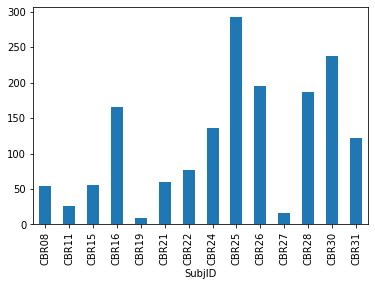

In [210]:
Features.groupby('SubjID').Steps.mean().plot(kind='bar')

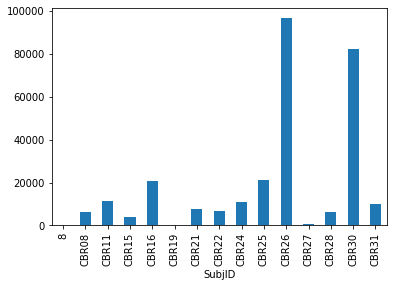

In [216]:
Features.groupby('SubjID').Steps.sum().plot(kind='bar')

In [188]:
Features.columns

Index(['Wear Frac', 'DestinationType', 'Distance', 'Duration', 'Mean Speed',
       'TripDuration', 'Relative_Freq', 'Relative_Duration', 'SubjID',
       'NewBrace', 'Steps', 'Steps per Hour', 'Steps per Hour Wear', 'Date',
       'Cadence', 'Age', 'Diagnosis', 'BaselineYrs', '6mwt', '10mwt_ss',
       '10mwt_fast'],
      dtype='object')

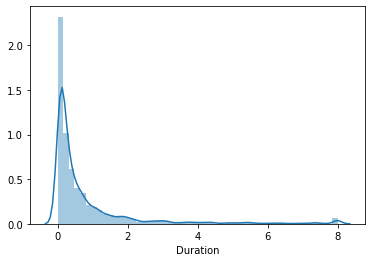

In [215]:
Features[Features['Duration'] > 8] = 8
sns.distplot(Features['Duration'])

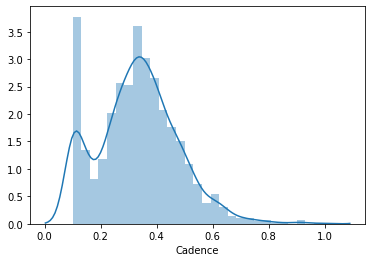

In [206]:
sns.distplot(Features['Cadence'])

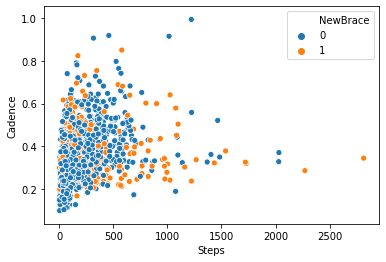

In [213]:
sns.scatterplot(x='Steps', y='Cadence', data=Features, hue='NewBrace')